In [35]:
import joblib
from scipy.stats import rankdata
from scipy.interpolate import UnivariateSpline
import pandas as pd
import os
from tqdm import tqdm
import numpy as np
from scipy.stats import pearsonr
import sys
import matplotlib.pyplot as plt

sys.path.append("../src")
from model import OnTheFlyModel, precalc_embeddings_reference, precalc_embeddings, HitSelectorByOverlap

hits, fid_prom, pid_prom = joblib.load(os.path.join("..", "data", "hits.joblib"))
fids, _, _ = joblib.load(os.path.join("..", "data", "cemm_emb.joblib"))
G = joblib.load("../graph_proteins.joblib")

proteome_reference_predictions_file = "../data/proteome_reference_predictions_07.joblib"
proteome_reference_predictions = joblib.load(proteome_reference_predictions_file)

uniprot_acs = [n for n in G.nodes()]


model = OnTheFlyModel()


def task_evaluator(model, uniprot_acs, tfidf, max_hit_fragments, max_fragment_promicuity, do_auroc=True):
    data = HitSelectorByOverlap(uniprot_acs, tfidf=tfidf).select(max_hit_fragments=max_hit_fragments, max_fragment_promiscuity=max_fragment_promicuity)
    model.baseline_classifier.fit(precalc_embeddings, data["y"])
    y_hat_ref = np.array(model.baseline_classifier.predict_proba(precalc_embeddings_reference)[:,1])
    rho = np.nanmean([pearsonr(y_hat_ref, proteome_reference_predictions[:,j])[0] for j in range(proteome_reference_predictions.shape[1])])
    if do_auroc:
        auroc = model.estimate_performance(data["y"], baseline=True, n_splits=10)
    else:
        auroc = (None, None)
    prom = np.mean(data[data["y"] == 1]["prom"])
    hits = np.mean(data[data["y"] == 1]["hits"])
    result = {
        "auroc": auroc,
        "prom": prom,
        "hits": hits,
        "ref_rho": rho
    }
    return result


def screen_max_hit_fragments(model, uniprot_acs, tfidf, max_fragment_promiscuity=500):
    cuts = [int(x) for x in np.arange(10, 210, 10)]
    aurocs = []
    proms = []
    hits = []
    ref_rhos = []
    for n in tqdm(cuts):
        results = task_evaluator(model, uniprot_acs, tfidf, n, max_fragment_promiscuity, do_auroc=False)
        aurocs += [results["auroc"][0]]
        proms += [results["prom"]]
        hits += [results["hits"]]
        ref_rhos += [results["ref_rho"]]
    return pd.DataFrame({"hit_cut": cuts, "auroc": aurocs, "prom": proms, "hits": hits, "ref_rho": ref_rhos})




data = screen_max_hit_fragments(model, uniprot_acs, tfidf=True)

100%|██████████| 20/20 [00:05<00:00,  3.62it/s]


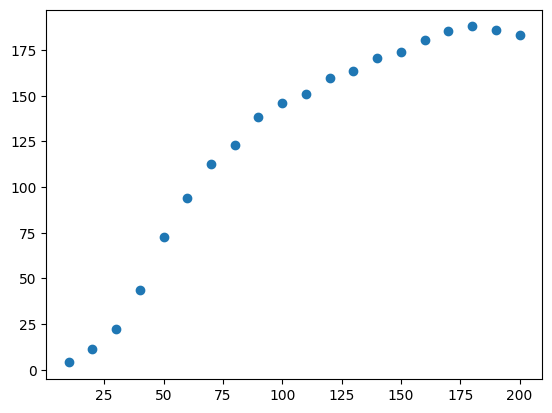

In [36]:
plt.scatter(data["hit_cut"], data["prom"])

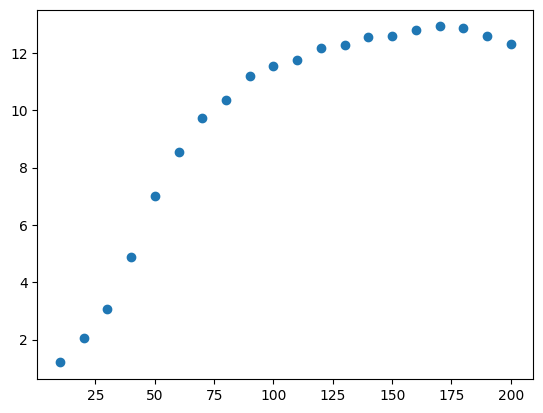

In [37]:
plt.scatter(data["hit_cut"], data["hits"])

In [29]:
from scipy.optimize import curve_fit

def find_inflection_point(x, y):
    def sigmoid(x, k, x0):
        y = 1 / (1 + np.exp(-k * (x - x0)))
        return y
    popt, _ = curve_fit(sigmoid, x, y, p0=[1, np.median(x)])
    return popt[1]

In [30]:
find_inflection_point(data["hit_cut"], data["ref_rho"])

/Users/mduranfrigola/miniconda3/envs/onthefly/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


171.5778269723927

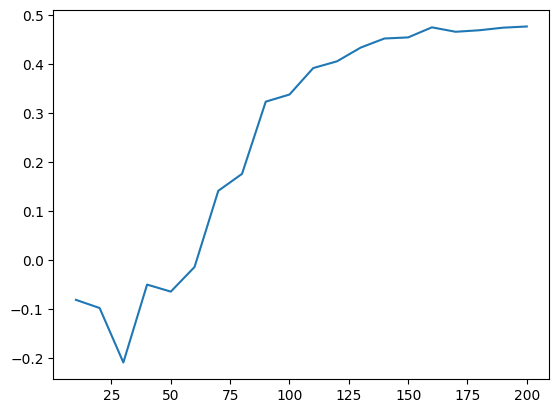

In [31]:
plt.plot(data["hit_cut"], data["ref_rho"])

In [26]:
x = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y = np.array([0.01, 0.02, 0.04, 0.2, 0.5, 0.8, 0.9, 0.95, 0.97, 0.99])
